# PARAMETERS 

In [1]:
janela = 6 #tamanho da Janela deslizante

problem_name = 'lstm_sales' #to save the models
model_architecture = 'VGG_16'
weights_path = None 
target_size = (224, 224) 
batch_size = 1

epochs = 100 #após x épocas sem melhorar pará (a usar callback)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import datetime
from keras.models import Sequential
from keras.layers.recurrent import LSTM
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

from keras.models import load_model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.embeddings import Embedding####################
from keras.preprocessing import sequence
from keras.constraints import maxnorm 
from keras.optimizers import SGD 
from keras.utils import np_utils 
from keras import backend as K 
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import keras
K.set_image_dim_ordering('tf') #ordem 'th' ou 'tf' 
from numpy import genfromtxt
import math 

from timeit import default_timer as timer
from time import time as tick
import matplotlib.pyplot as plt 
import pickle 
from os import listdir
from PIL import Image, ImageOps
from os.path import isfile, join
import os
from scipy.misc	import toimage 
from scipy import misc, ndimage
import scipy.fftpack as pack
import scipy.misc
from scipy.ndimage import rotate
from sklearn.datasets import fetch_mldata
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import roc_auc_score
import pathlib
import datetime

/home/programs/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#função load_data do lstm.py configurada para aceitar qualquer número de parametros
#o último atributo é que fica como label (resultado)
#stock é um dataframe do pandas (uma especie de dicionario + matriz)
#seq_len é o tamanho da janela a ser utilizada na serie temporal
def load_data(df_dados, janela):
    qt_atributos = len(df_dados.columns)
    mat_dados = df_dados.as_matrix() #converter dataframe para matriz (lista com lista de cada registo)
    tam_sequencia = janela + 1
    res = []
    for i in range(len(mat_dados) - janela): #numero de registos - tamanho da sequencia
        res.append(mat_dados[i: i + tam_sequencia])
    
    res = np.array(res) #dá como resultado um np com uma lista de matrizes (janela deslizante ao longo da serie)

    #qt_casos_treino = int(round(0.9 * res.shape[0])) #90% passam a ser casos de treino
    
    qt_casos_treino = 24 # 2 anos
    #qt_casos_test = 12 - janela
    
    x_train = res[:qt_casos_treino, :-1] #menos um registo pois o ultimo registo é o registo a seguir à janela
    y_train = res[:qt_casos_treino, -1][:,-1] #para ir buscar o último atributo para a lista dos labels
    x_test = res[qt_casos_treino:, :-1]
    y_test = res[qt_casos_treino:, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], qt_atributos))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], qt_atributos))
    return [x_train, y_train, x_test, y_test]

#imprime um grafico com os valores de teste e com as correspondentes tabela de previsões
def print_series_prediction(y_test,predic):
    diff=[]
    racio=[]
    for i in range(len(y_test)): #para imprimir tabela de previsoes
        racio.append( (y_test[i]/predic[i])-1)
        diff.append( abs(y_test[i]- predic[i]))
        print('valor: %f ---> Previsão: %f Diff: %f Racio: %f' % (y_test[i], predic[i], diff[i], racio[i]))
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction') #este deu uma linha em branco
    plt.plot(diff,color='green', label='diff')
    plt.plot(racio,color='yellow', label='racio')
    plt.legend(loc='upper left')
    plt.show()
    
    


def print_model(model,fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)
    
def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['mean_squared_error'])
    plt.title('mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def load_batch(fpath, label_key='labels'): 
 
    f = open(fpath, 'rb') 
    d = pickle.load(f, encoding='bytes') 
    d_decoded = {}        # decode utf8 
    for k, v in d.items(): 
        d_decoded[k.decode('utf8')] = v 
    d = d_decoded 
    f.close() 
    data = d['data'] 
    labels = d[label_key] 
    data = data.reshape(data.shape[0], 3, 32, 32) 
    return data, labels


def rotate_resize(temp, tam_image):
    #-------------------rodar se necessário e cortar em quadrado
    if temp.shape[0] > temp.shape[1]:
        temp = rotate(temp,90)
    
    #cortar em quadrado no centro da imagem e fazer resize para o tam_image
    difShapes = temp.shape[1]-temp.shape[0]
    return (255 * resize(temp[0:temp.shape[0],int(difShapes/2):int(difShapes/2)+temp.shape[0]],
                            (tam_image, tam_image))).astype(np.uint8)

In [4]:
def read_and_pre_process():
    file_name = 'advertising-and-sales-data-36-co.csv'
    col_names = 'date', 'pub', 'sales'
    dataset = pd.read_csv(file_name, sep = ';', header=0, names=col_names) #3 colunas
    df = pd.DataFrame(dataset)
    date_split = df['date'].str.split('-').str
    df['year'], df['month'] = date_split #acrescentar ano e mes separados
    df.drop(df.columns[[0]], axis=1, inplace=True) #eliminar data original

    df = df[:-1] #eliminar a ultima linha porque é uma frase informativa

    #vamos passar ano e mes para para strings para não ser interpretado como valores

    look_up = {'1': 'First', '2': 'Second', '3': 'Third'}
    #df['year'] = df['year'].apply(lambda x: look_up[x])

    look_up = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May',
                '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

    #df['month'] = df['month'].apply(lambda x: look_up[x])

    df = df[['year', 'month', 'pub', 'sales']]
    return df

# Models

In [5]:
def build_model7(janela, nmr_parametros):
    #embedding_vecor_length = 32
    
    model = Sequential()
    
    model.add(BatchNormalization(input_shape=(janela, nmr_parametros)))
    model.add(LSTM(256, input_shape=(janela, nmr_parametros), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(BatchNormalization(input_shape=(janela, nmr_parametros)))
    model.add(LSTM(128, input_shape=(janela, nmr_parametros), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(BatchNormalization(input_shape=(janela, nmr_parametros)))
    model.add(LSTM(64, input_shape=(janela, nmr_parametros), return_sequences=False))
    model.add(Dropout(0.5))
    
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
    model.compile(loss='mean_squared_error',optimizer='sgd',metrics=['mse'])
    return model

# Callbacks

In [6]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history_loss = LossHistory() #print(history.losses) to use      

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min')    

checkpoint = ModelCheckpoint(filepath = 'checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='mean_squared_error', save_best_only=True, mode='min', period=1)

#reduce training rate when no improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('training.log')

# Training

   year month   pub  sales
0     1    01  12.0   15.0
1     1    02  20.5   16.0
2     1    03  21.0   18.0
3     1    04  15.5   27.0
4     1    05  15.3   21.0
5     1    06  23.5   49.0
6     1    07  24.5   21.0
7     1    08  21.3   22.0
8     1    09  23.5   28.0
9     1    10  28.0   36.0
10    1    11  24.0   40.0
11    1    12  15.5    3.0
12    2    01  17.3   21.0
13    2    02  25.3   29.0
14    2    03  25.0   62.0
15    2    04  36.5   65.0
16    2    05  36.5   46.0
17    2    06  29.6   44.0
18    2    07  30.5   33.0
19    2    08  28.0   62.0
20    2    09  26.0   22.0
21    2    10  21.5   12.0
22    2    11  19.7   24.0
23    2    12  19.0    3.0
24    3    01  16.0    5.0
25    3    02  20.7   14.0
26    3    03  26.5   36.0
27    3    04  30.6   40.0
28    3    05  32.3   49.0
29    3    06  29.5    7.0
30    3    07  28.3   52.0
31    3    08  31.3   65.0
32    3    09  32.2   17.0
33    3    10  26.4    5.0
34    3    11  23.4   17.0
35    3    12  16.4    1.0
X

Epoch 32/1000
21/21 [==============================] - 0s 1ms/step - loss: 166.1608 - mean_squared_error: 166.1608 - val_loss: 501.0765 - val_mean_squared_error: 501.0765
Epoch 33/1000
21/21 [==============================] - 0s 1ms/step - loss: 184.4612 - mean_squared_error: 184.4612 - val_loss: 416.5460 - val_mean_squared_error: 416.5460
Epoch 34/1000
21/21 [==============================] - 0s 1ms/step - loss: 376.6824 - mean_squared_error: 376.6824 - val_loss: 1005.3333 - val_mean_squared_error: 1005.3333
Epoch 35/1000
21/21 [==============================] - 0s 1ms/step - loss: 202.0615 - mean_squared_error: 202.0615 - val_loss: 368.7171 - val_mean_squared_error: 368.7171
Epoch 36/1000
21/21 [==============================] - 0s 1ms/step - loss: 280.7206 - mean_squared_error: 280.7206 - val_loss: 1330.3727 - val_mean_squared_error: 1330.3727
Epoch 37/1000
21/21 [==============================] - 0s 1ms/step - loss: 324.2688 - mean_squared_error: 324.2688 - val_loss: 841.4030 - val

Epoch 80/1000
21/21 [==============================] - 0s 1ms/step - loss: 176.3626 - mean_squared_error: 176.3626 - val_loss: 649.6412 - val_mean_squared_error: 649.6412
Epoch 81/1000
21/21 [==============================] - 0s 1ms/step - loss: 85.4363 - mean_squared_error: 85.4363 - val_loss: 327.8780 - val_mean_squared_error: 327.8780
Epoch 82/1000
21/21 [==============================] - 0s 1ms/step - loss: 151.1967 - mean_squared_error: 151.1967 - val_loss: 578.4102 - val_mean_squared_error: 578.4102
Epoch 83/1000
21/21 [==============================] - 0s 1ms/step - loss: 82.7749 - mean_squared_error: 82.7749 - val_loss: 335.8253 - val_mean_squared_error: 335.8253
Epoch 84/1000
21/21 [==============================] - 0s 2ms/step - loss: 160.6319 - mean_squared_error: 160.6319 - val_loss: 948.6250 - val_mean_squared_error: 948.6250
Epoch 85/1000
21/21 [==============================] - 0s 1ms/step - loss: 161.4924 - mean_squared_error: 161.4924 - val_loss: 483.6839 - val_mean_sq

Epoch 129/1000
21/21 [==============================] - 0s 1ms/step - loss: 154.9195 - mean_squared_error: 154.9195 - val_loss: 718.4516 - val_mean_squared_error: 718.4516
Epoch 130/1000
21/21 [==============================] - 0s 2ms/step - loss: 53.1018 - mean_squared_error: 53.1018 - val_loss: 427.2397 - val_mean_squared_error: 427.2397
Epoch 131/1000
21/21 [==============================] - 0s 1ms/step - loss: 28.8111 - mean_squared_error: 28.8111 - val_loss: 397.0029 - val_mean_squared_error: 397.0029
Epoch 132/1000
21/21 [==============================] - 0s 1ms/step - loss: 69.1440 - mean_squared_error: 69.1440 - val_loss: 720.5903 - val_mean_squared_error: 720.5903
Epoch 133/1000
21/21 [==============================] - 0s 1ms/step - loss: 73.0207 - mean_squared_error: 73.0207 - val_loss: 391.4865 - val_mean_squared_error: 391.4865
Epoch 134/1000
21/21 [==============================] - 0s 2ms/step - loss: 44.7208 - mean_squared_error: 44.7208 - val_loss: 807.5980 - val_mean_sq

21/21 [==============================] - 0s 1ms/step - loss: 85.2012 - mean_squared_error: 85.2012 - val_loss: 419.4920 - val_mean_squared_error: 419.4920
Epoch 178/1000
21/21 [==============================] - 0s 1ms/step - loss: 70.4349 - mean_squared_error: 70.4349 - val_loss: 598.6714 - val_mean_squared_error: 598.6714
Epoch 179/1000
21/21 [==============================] - 0s 1ms/step - loss: 57.0358 - mean_squared_error: 57.0358 - val_loss: 512.9852 - val_mean_squared_error: 512.9852
Epoch 180/1000
21/21 [==============================] - 0s 1ms/step - loss: 66.2927 - mean_squared_error: 66.2927 - val_loss: 505.0730 - val_mean_squared_error: 505.0730
Epoch 181/1000
21/21 [==============================] - 0s 1ms/step - loss: 34.8231 - mean_squared_error: 34.8231 - val_loss: 539.0854 - val_mean_squared_error: 539.0854
Epoch 182/1000
21/21 [==============================] - 0s 1ms/step - loss: 39.0765 - mean_squared_error: 39.0765 - val_loss: 419.0308 - val_mean_squared_error: 419.

Epoch 226/1000
21/21 [==============================] - 0s 2ms/step - loss: 57.4380 - mean_squared_error: 57.4380 - val_loss: 348.0439 - val_mean_squared_error: 348.0439
Epoch 227/1000
21/21 [==============================] - 0s 2ms/step - loss: 94.1697 - mean_squared_error: 94.1697 - val_loss: 1056.1075 - val_mean_squared_error: 1056.1075
Epoch 228/1000
21/21 [==============================] - 0s 2ms/step - loss: 65.0624 - mean_squared_error: 65.0624 - val_loss: 338.3338 - val_mean_squared_error: 338.3338
Epoch 229/1000
21/21 [==============================] - 0s 2ms/step - loss: 66.6460 - mean_squared_error: 66.6460 - val_loss: 658.8589 - val_mean_squared_error: 658.8589
Epoch 230/1000
21/21 [==============================] - 0s 2ms/step - loss: 47.4926 - mean_squared_error: 47.4926 - val_loss: 317.2121 - val_mean_squared_error: 317.2121
Epoch 231/1000
21/21 [==============================] - 0s 2ms/step - loss: 58.8050 - mean_squared_error: 58.8050 - val_loss: 512.3122 - val_mean_sq

Epoch 275/1000
21/21 [==============================] - 0s 2ms/step - loss: 37.2950 - mean_squared_error: 37.2950 - val_loss: 712.3854 - val_mean_squared_error: 712.3854
Epoch 276/1000
21/21 [==============================] - 0s 2ms/step - loss: 34.9335 - mean_squared_error: 34.9335 - val_loss: 500.0233 - val_mean_squared_error: 500.0233
Epoch 277/1000
21/21 [==============================] - 0s 2ms/step - loss: 25.7868 - mean_squared_error: 25.7868 - val_loss: 657.8929 - val_mean_squared_error: 657.8929
Epoch 278/1000
21/21 [==============================] - 0s 2ms/step - loss: 16.1157 - mean_squared_error: 16.1157 - val_loss: 563.2990 - val_mean_squared_error: 563.2990
Epoch 279/1000
21/21 [==============================] - 0s 2ms/step - loss: 11.3235 - mean_squared_error: 11.3235 - val_loss: 586.9354 - val_mean_squared_error: 586.9354
Epoch 280/1000
21/21 [==============================] - 0s 2ms/step - loss: 29.9269 - mean_squared_error: 29.9269 - val_loss: 860.9566 - val_mean_squa

Epoch 324/1000
21/21 [==============================] - 0s 2ms/step - loss: 13.7185 - mean_squared_error: 13.7185 - val_loss: 728.5898 - val_mean_squared_error: 728.5898
Epoch 325/1000
21/21 [==============================] - 0s 2ms/step - loss: 11.3448 - mean_squared_error: 11.3448 - val_loss: 648.0722 - val_mean_squared_error: 648.0722
Epoch 326/1000
21/21 [==============================] - 0s 1ms/step - loss: 20.6985 - mean_squared_error: 20.6985 - val_loss: 558.6191 - val_mean_squared_error: 558.6191
Epoch 327/1000
21/21 [==============================] - 0s 2ms/step - loss: 36.6655 - mean_squared_error: 36.6655 - val_loss: 822.4970 - val_mean_squared_error: 822.4970
Epoch 328/1000
21/21 [==============================] - 0s 1ms/step - loss: 50.1258 - mean_squared_error: 50.1258 - val_loss: 482.2932 - val_mean_squared_error: 482.2932
Epoch 329/1000
21/21 [==============================] - 0s 1ms/step - loss: 34.5185 - mean_squared_error: 34.5185 - val_loss: 660.4832 - val_mean_squa

Epoch 373/1000
21/21 [==============================] - 0s 1ms/step - loss: 38.4912 - mean_squared_error: 38.4912 - val_loss: 433.5747 - val_mean_squared_error: 433.5747
Epoch 374/1000
21/21 [==============================] - 0s 1ms/step - loss: 54.2398 - mean_squared_error: 54.2398 - val_loss: 764.0760 - val_mean_squared_error: 764.0760
Epoch 375/1000
21/21 [==============================] - 0s 1ms/step - loss: 17.6184 - mean_squared_error: 17.6184 - val_loss: 580.0055 - val_mean_squared_error: 580.0055
Epoch 376/1000
21/21 [==============================] - 0s 1ms/step - loss: 6.7006 - mean_squared_error: 6.7006 - val_loss: 608.4615 - val_mean_squared_error: 608.4615
Epoch 377/1000
21/21 [==============================] - 0s 2ms/step - loss: 17.7095 - mean_squared_error: 17.7095 - val_loss: 616.0751 - val_mean_squared_error: 616.0751
Epoch 378/1000
21/21 [==============================] - 0s 2ms/step - loss: 18.4293 - mean_squared_error: 18.4293 - val_loss: 577.2501 - val_mean_square

Epoch 422/1000
21/21 [==============================] - 0s 2ms/step - loss: 28.7720 - mean_squared_error: 28.7720 - val_loss: 643.7755 - val_mean_squared_error: 643.7755
Epoch 423/1000
21/21 [==============================] - 0s 1ms/step - loss: 18.2408 - mean_squared_error: 18.2408 - val_loss: 611.1630 - val_mean_squared_error: 611.1630
Epoch 424/1000
21/21 [==============================] - 0s 1ms/step - loss: 13.7278 - mean_squared_error: 13.7278 - val_loss: 550.2911 - val_mean_squared_error: 550.2911
Epoch 425/1000
21/21 [==============================] - 0s 2ms/step - loss: 15.9257 - mean_squared_error: 15.9257 - val_loss: 552.5563 - val_mean_squared_error: 552.5563
Epoch 426/1000
21/21 [==============================] - 0s 1ms/step - loss: 10.2677 - mean_squared_error: 10.2677 - val_loss: 522.8024 - val_mean_squared_error: 522.8024
Epoch 427/1000
21/21 [==============================] - 0s 1ms/step - loss: 14.4976 - mean_squared_error: 14.4976 - val_loss: 569.6584 - val_mean_squa

Epoch 471/1000
21/21 [==============================] - 0s 2ms/step - loss: 17.8513 - mean_squared_error: 17.8513 - val_loss: 586.3090 - val_mean_squared_error: 586.3090
Epoch 472/1000
21/21 [==============================] - 0s 1ms/step - loss: 19.7441 - mean_squared_error: 19.7441 - val_loss: 622.4323 - val_mean_squared_error: 622.4323
Epoch 473/1000
21/21 [==============================] - 0s 1ms/step - loss: 15.8135 - mean_squared_error: 15.8135 - val_loss: 424.6008 - val_mean_squared_error: 424.6008
Epoch 474/1000
21/21 [==============================] - 0s 1ms/step - loss: 19.7378 - mean_squared_error: 19.7378 - val_loss: 565.9800 - val_mean_squared_error: 565.9800
Epoch 475/1000
21/21 [==============================] - 0s 1ms/step - loss: 7.3263 - mean_squared_error: 7.3263 - val_loss: 576.2228 - val_mean_squared_error: 576.2228
Epoch 476/1000
21/21 [==============================] - 0s 1ms/step - loss: 20.5635 - mean_squared_error: 20.5635 - val_loss: 512.0181 - val_mean_square

Epoch 520/1000
21/21 [==============================] - 0s 2ms/step - loss: 20.8227 - mean_squared_error: 20.8227 - val_loss: 492.1506 - val_mean_squared_error: 492.1506
Epoch 521/1000
21/21 [==============================] - 0s 2ms/step - loss: 14.4009 - mean_squared_error: 14.4009 - val_loss: 532.1840 - val_mean_squared_error: 532.1840
Epoch 522/1000
21/21 [==============================] - 0s 2ms/step - loss: 11.7512 - mean_squared_error: 11.7512 - val_loss: 477.0569 - val_mean_squared_error: 477.0569
Epoch 523/1000
21/21 [==============================] - 0s 2ms/step - loss: 25.8776 - mean_squared_error: 25.8776 - val_loss: 700.2568 - val_mean_squared_error: 700.2568
Epoch 524/1000
21/21 [==============================] - 0s 2ms/step - loss: 13.0929 - mean_squared_error: 13.0929 - val_loss: 514.8787 - val_mean_squared_error: 514.8787
Epoch 525/1000
21/21 [==============================] - 0s 2ms/step - loss: 9.1680 - mean_squared_error: 9.1680 - val_loss: 532.6202 - val_mean_square

Epoch 569/1000
21/21 [==============================] - 0s 2ms/step - loss: 22.9768 - mean_squared_error: 22.9768 - val_loss: 611.9543 - val_mean_squared_error: 611.9543
Epoch 570/1000
21/21 [==============================] - 0s 2ms/step - loss: 12.9395 - mean_squared_error: 12.9395 - val_loss: 572.5112 - val_mean_squared_error: 572.5112
Epoch 571/1000
21/21 [==============================] - 0s 2ms/step - loss: 10.1804 - mean_squared_error: 10.1804 - val_loss: 656.5526 - val_mean_squared_error: 656.5526
Epoch 572/1000
21/21 [==============================] - 0s 2ms/step - loss: 12.6766 - mean_squared_error: 12.6766 - val_loss: 517.3069 - val_mean_squared_error: 517.3069
Epoch 573/1000
21/21 [==============================] - 0s 2ms/step - loss: 12.6880 - mean_squared_error: 12.6880 - val_loss: 661.2040 - val_mean_squared_error: 661.2040
Epoch 574/1000
21/21 [==============================] - 0s 1ms/step - loss: 17.4390 - mean_squared_error: 17.4390 - val_loss: 475.7986 - val_mean_squa

Epoch 618/1000
21/21 [==============================] - 0s 1ms/step - loss: 10.2130 - mean_squared_error: 10.2130 - val_loss: 535.1332 - val_mean_squared_error: 535.1332
Epoch 619/1000
21/21 [==============================] - 0s 1ms/step - loss: 13.5959 - mean_squared_error: 13.5959 - val_loss: 664.4978 - val_mean_squared_error: 664.4978
Epoch 620/1000
21/21 [==============================] - 0s 2ms/step - loss: 7.6561 - mean_squared_error: 7.6561 - val_loss: 707.3316 - val_mean_squared_error: 707.3316
Epoch 621/1000
21/21 [==============================] - 0s 2ms/step - loss: 27.5123 - mean_squared_error: 27.5123 - val_loss: 467.9021 - val_mean_squared_error: 467.9021
Epoch 622/1000
21/21 [==============================] - 0s 2ms/step - loss: 22.2307 - mean_squared_error: 22.2307 - val_loss: 597.0922 - val_mean_squared_error: 597.0922
Epoch 623/1000
21/21 [==============================] - 0s 2ms/step - loss: 18.0736 - mean_squared_error: 18.0736 - val_loss: 437.0553 - val_mean_square

Epoch 667/1000
21/21 [==============================] - 0s 1ms/step - loss: 9.4233 - mean_squared_error: 9.4233 - val_loss: 547.0550 - val_mean_squared_error: 547.0550
Epoch 668/1000
21/21 [==============================] - 0s 1ms/step - loss: 12.2530 - mean_squared_error: 12.2530 - val_loss: 580.4512 - val_mean_squared_error: 580.4512
Epoch 669/1000
21/21 [==============================] - 0s 1ms/step - loss: 8.8122 - mean_squared_error: 8.8122 - val_loss: 513.4097 - val_mean_squared_error: 513.4097
Epoch 670/1000
21/21 [==============================] - 0s 1ms/step - loss: 19.7902 - mean_squared_error: 19.7902 - val_loss: 672.3903 - val_mean_squared_error: 672.3903
Epoch 671/1000
21/21 [==============================] - 0s 1ms/step - loss: 24.4820 - mean_squared_error: 24.4820 - val_loss: 454.0761 - val_mean_squared_error: 454.0761
Epoch 672/1000
21/21 [==============================] - 0s 1ms/step - loss: 15.6294 - mean_squared_error: 15.6294 - val_loss: 562.2542 - val_mean_squared_

Epoch 716/1000
21/21 [==============================] - 0s 2ms/step - loss: 8.4901 - mean_squared_error: 8.4901 - val_loss: 430.5758 - val_mean_squared_error: 430.5758
Epoch 717/1000
21/21 [==============================] - 0s 2ms/step - loss: 6.5581 - mean_squared_error: 6.5581 - val_loss: 493.1680 - val_mean_squared_error: 493.1680
Epoch 718/1000
21/21 [==============================] - 0s 1ms/step - loss: 13.8894 - mean_squared_error: 13.8894 - val_loss: 594.9557 - val_mean_squared_error: 594.9557
Epoch 719/1000
21/21 [==============================] - 0s 2ms/step - loss: 66.1999 - mean_squared_error: 66.1999 - val_loss: 358.1373 - val_mean_squared_error: 358.1373
Epoch 720/1000
21/21 [==============================] - 0s 2ms/step - loss: 108.6810 - mean_squared_error: 108.6810 - val_loss: 643.3048 - val_mean_squared_error: 643.3048
Epoch 721/1000
21/21 [==============================] - 0s 2ms/step - loss: 14.9091 - mean_squared_error: 14.9091 - val_loss: 575.8987 - val_mean_square

Epoch 765/1000
21/21 [==============================] - 0s 2ms/step - loss: 14.8830 - mean_squared_error: 14.8830 - val_loss: 704.7441 - val_mean_squared_error: 704.7441
Epoch 766/1000
21/21 [==============================] - 0s 2ms/step - loss: 8.0769 - mean_squared_error: 8.0769 - val_loss: 546.2233 - val_mean_squared_error: 546.2233
Epoch 767/1000
21/21 [==============================] - 0s 2ms/step - loss: 15.6981 - mean_squared_error: 15.6981 - val_loss: 694.4799 - val_mean_squared_error: 694.4799
Epoch 768/1000
21/21 [==============================] - 0s 2ms/step - loss: 21.2258 - mean_squared_error: 21.2258 - val_loss: 435.2732 - val_mean_squared_error: 435.2732
Epoch 769/1000
21/21 [==============================] - 0s 2ms/step - loss: 13.7955 - mean_squared_error: 13.7955 - val_loss: 564.3109 - val_mean_squared_error: 564.3109
Epoch 770/1000
21/21 [==============================] - 0s 2ms/step - loss: 18.4594 - mean_squared_error: 18.4594 - val_loss: 555.9966 - val_mean_square

Epoch 814/1000
21/21 [==============================] - 0s 1ms/step - loss: 12.8632 - mean_squared_error: 12.8632 - val_loss: 625.4636 - val_mean_squared_error: 625.4636
Epoch 815/1000
21/21 [==============================] - 0s 2ms/step - loss: 7.8107 - mean_squared_error: 7.8107 - val_loss: 552.9921 - val_mean_squared_error: 552.9921
Epoch 816/1000
21/21 [==============================] - 0s 1ms/step - loss: 14.9552 - mean_squared_error: 14.9552 - val_loss: 690.8621 - val_mean_squared_error: 690.8621
Epoch 817/1000
21/21 [==============================] - 0s 1ms/step - loss: 9.1234 - mean_squared_error: 9.1234 - val_loss: 582.7368 - val_mean_squared_error: 582.7368
Epoch 818/1000
21/21 [==============================] - 0s 2ms/step - loss: 6.6368 - mean_squared_error: 6.6368 - val_loss: 664.2637 - val_mean_squared_error: 664.2637
Epoch 819/1000
21/21 [==============================] - 0s 1ms/step - loss: 10.3756 - mean_squared_error: 10.3756 - val_loss: 672.2844 - val_mean_squared_er

Epoch 863/1000
21/21 [==============================] - 0s 1ms/step - loss: 13.6876 - mean_squared_error: 13.6876 - val_loss: 491.2205 - val_mean_squared_error: 491.2205
Epoch 864/1000
21/21 [==============================] - 0s 2ms/step - loss: 9.5299 - mean_squared_error: 9.5299 - val_loss: 605.4193 - val_mean_squared_error: 605.4193
Epoch 865/1000
21/21 [==============================] - 0s 2ms/step - loss: 11.0785 - mean_squared_error: 11.0785 - val_loss: 548.7503 - val_mean_squared_error: 548.7503
Epoch 866/1000
21/21 [==============================] - 0s 1ms/step - loss: 11.9117 - mean_squared_error: 11.9117 - val_loss: 576.0805 - val_mean_squared_error: 576.0805
Epoch 867/1000
21/21 [==============================] - 0s 1ms/step - loss: 7.1481 - mean_squared_error: 7.1481 - val_loss: 503.5000 - val_mean_squared_error: 503.5000
Epoch 868/1000
21/21 [==============================] - 0s 1ms/step - loss: 8.0418 - mean_squared_error: 8.0418 - val_loss: 488.4943 - val_mean_squared_er

Epoch 912/1000
21/21 [==============================] - 0s 2ms/step - loss: 27.6925 - mean_squared_error: 27.6925 - val_loss: 649.7825 - val_mean_squared_error: 649.7825
Epoch 913/1000
21/21 [==============================] - 0s 2ms/step - loss: 12.1851 - mean_squared_error: 12.1851 - val_loss: 679.2059 - val_mean_squared_error: 679.2059
Epoch 914/1000
21/21 [==============================] - 0s 2ms/step - loss: 23.0773 - mean_squared_error: 23.0773 - val_loss: 456.7899 - val_mean_squared_error: 456.7899
Epoch 915/1000
21/21 [==============================] - 0s 2ms/step - loss: 22.8247 - mean_squared_error: 22.8247 - val_loss: 657.4270 - val_mean_squared_error: 657.4270
Epoch 916/1000
21/21 [==============================] - 0s 2ms/step - loss: 22.1789 - mean_squared_error: 22.1789 - val_loss: 488.5681 - val_mean_squared_error: 488.5681
Epoch 917/1000
21/21 [==============================] - 0s 2ms/step - loss: 21.0534 - mean_squared_error: 21.0534 - val_loss: 643.3365 - val_mean_squa

Epoch 961/1000
21/21 [==============================] - 0s 2ms/step - loss: 6.7344 - mean_squared_error: 6.7344 - val_loss: 581.1083 - val_mean_squared_error: 581.1083
Epoch 962/1000
21/21 [==============================] - 0s 2ms/step - loss: 5.5338 - mean_squared_error: 5.5338 - val_loss: 583.8613 - val_mean_squared_error: 583.8613
Epoch 963/1000
21/21 [==============================] - 0s 2ms/step - loss: 9.4969 - mean_squared_error: 9.4969 - val_loss: 544.3604 - val_mean_squared_error: 544.3604
Epoch 964/1000
21/21 [==============================] - 0s 2ms/step - loss: 7.1164 - mean_squared_error: 7.1164 - val_loss: 532.7721 - val_mean_squared_error: 532.7721
Epoch 965/1000
21/21 [==============================] - 0s 2ms/step - loss: 9.7806 - mean_squared_error: 9.7806 - val_loss: 552.3986 - val_mean_squared_error: 552.3986
Epoch 966/1000
21/21 [==============================] - 0s 2ms/step - loss: 8.7089 - mean_squared_error: 8.7089 - val_loss: 574.6474 - val_mean_squared_error: 5

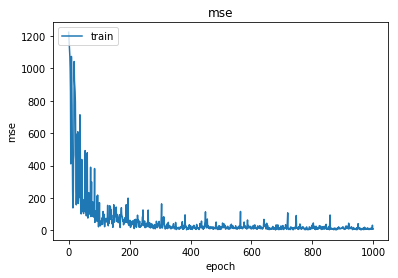

Train Score: 76.65 MSE (8.76 RMSE)
Test Score: 92.82 MSE (9.63 RMSE)
['loss', 'mean_squared_error']
valor: 52.000000 ---> Previsão: 58.747875 Diff: 6.747875 Racio: -0.114862
valor: 65.000000 ---> Previsão: 53.298134 Diff: 11.701866 Racio: 0.219555
valor: 17.000000 ---> Previsão: 18.446444 Diff: 1.446444 Racio: -0.078413
valor: 5.000000 ---> Previsão: 11.910640 Diff: 6.910640 Racio: -0.580207
valor: 17.000000 ---> Previsão: 16.841610 Diff: 0.158390 Racio: 0.009405
valor: 1.000000 ---> Previsão: 19.015900 Diff: 18.015900 Racio: -0.947412


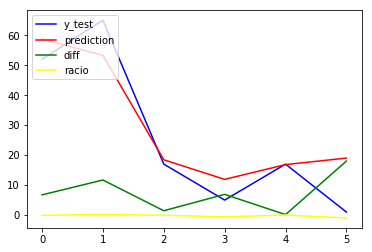

In [13]:
if __name__ == '__main__':
    df = read_and_pre_process()
    print(df)
    X_train, y_train, X_test, y_test = load_data(df, janela)# o df[::-1] é o df por ordem inversa

    #max_review_length = 10
    #x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
    #x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    
    nmr_parametros = X_train.shape[2]
    
    model = build_model7(janela, nmr_parametros)
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size=512, epochs=1000, validation_split=0.1, verbose=1, callbacks = [checkpoint])
    
    print_history_accuracy(history) 
    
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    
    print(model.metrics_names)
    p = model.predict(X_test)
    predic = np.squeeze(np.asarray(p)) #transformar uma matriz de uma coluna e n linhas em um np array de n elementos
    print_series_prediction(y_test,predic)
    
    
    ''' 
    MSE- (Mean square error), RMSE- (root mean square error) –
    o significado de RMSE depende do range da label. para o mesmo range menor é melhor.
    '''